# Imports

In [2]:
import numpy as np
from scipy import stats
import math
from math import floor
import argparse
import matplotlib.pyplot as plt
import os
import csv
import pymc as pm
import arviz as az
import warnings
import pandas as pd

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Initializing the parameters

In [3]:
## Fixed hyperparameters
initial_users = 20
initial_groups = 10
initial_communities = 5

# group and community preferences
alpha_group_hyperparameter = 10
beta_group_hyperparameter = 10
alpha_community_hyperparameter = 10
beta_community_hyperparameter = 10

# Initialize lists to store users and groups
users = []
groups = []
communities = []

gis = {}
cis = {}
uis = {}

# Initializations
num_timesteps = 100
user_growth_rate = 1
interaction_threshold = 1.01

new_group_rate = 0.5
new_group_join_chance = new_group_rate / 10

new_community_rate = 0.25
new_community_join_chance = new_community_rate / 10

same_community_interaction_ratio = new_community_rate * new_group_rate

# Creating Classes

In [4]:
class Community:
    def __init__(self, group=None):
        # Initialize a community with a list of users and groups
        self.id = len(communities) + 1
        self.groups = [group] if group else []
        self.interactions = []


class Group:
    def __init__(self):
        # Initialize a group with an ID and a dictionary tgo track user interactions
        self.id = len(groups) + 1
        self.interactions = {}
        self.community = None

    def join_community(self, community):
        community.groups.append(self)
        self.community = community


class User:
    def __init__(self, group_alpha, group_beta, community_alpha, community_beta):
        # Initialize a user with ID, group memberships, interaction history, and Beta distribution preferences
        self.id = None

        self.groups = []
        self.communities = []
        self.interaction_history = []

        self.group_preferences = stats.beta(group_alpha, group_beta)
        self.community_preferences = stats.beta(community_alpha, community_beta)
        self.updated_preferences = np.array([1])

    def update_preferences(self):
        # Update user's preferences based on group interactions
        if not self.groups:
            self.updated_preferences = np.array([1])
            return
        else:
            # sort groups by number of interactions
            self.groups.sort(key=lambda group: len(group.interactions))

        total_size = sum([len(group.interactions) for group in self.groups])

        # if size is 0, this must be the first iteration, return uniform
        if total_size == 0:
            self.ccdf = np.array([1])
            return
        else:
            sizes = sorted([len(group.interactions) for group in self.groups])
            self.ccdf = 1 - (np.cumsum(sizes) / total_size)

        group_convolution = np.convolve(
            self.group_preferences.pdf(np.linspace(0, 1, len(self.groups))),
            self.ccdf,
            mode="same",
        )

        self.updated_preferences = np.convolve(
            group_convolution,
            self.community_preferences.pdf(np.linspace(0, 1, len(self.groups))),
            mode="same",
        )

        if (
            np.isnan(self.updated_preferences).any()
            or np.sum(self.updated_preferences) == 0
        ):
            self.updated_preferences = np.array(
                [1 / len(self.groups)] * len(self.groups)
            )
        else:
            self.updated_preferences /= np.sum(self.updated_preferences)

    def join_group(self, group):
        # Add a group to the user's group list and set initial interactions to 0
        self.groups.append(group)
        group.interactions[self] = 0

    def interact(self, group):
        # Record an interaction with the specified group
        group.interactions[self] = group.interactions.get(self, 0) + 1
        self.interaction_history.append(group.id)

# Initializing and Running

#### Defining the functions

In [5]:
# Recalculate probabilities at every iteration or after any changes
def calculate_probabilities():
    global community_relative_frequency, group_relative_frequency

    community_relative_frequency = np.array(
        [len(community.groups) for community in communities], dtype=float
    )
    # if community_relative_frequency.sum() != 0:
    community_relative_frequency += 1e-5  # Avoid division by zero
    community_relative_frequency /= community_relative_frequency.sum()

    group_relative_frequency = np.array(
        [sum(group.interactions.values()) for group in groups], dtype=float
    )
    # if group_relative_frequency.sum() != 0:
    group_relative_frequency += 1e-5
    group_relative_frequency /= group_relative_frequency.sum()


def initialize():
    # Initialize users
    for i in range(initial_users):
        users.append(
            User(
                alpha_group_hyperparameter,
                beta_group_hyperparameter,
                alpha_community_hyperparameter,
                beta_community_hyperparameter,
            )
        )
        users[-1].id = len(users)

    # Initialize communities
    for i in range(initial_communities):
        communities.append(Community())

    # Initialize groups
    for i in range(initial_groups):
        groups.append(Group())

    # adding the first groups to each community so there is at least one group in each community
    for i in range(len(communities)):
        groups[i].join_community(communities[i])
        # random chance for each user to join the first group of a new community
        for user in users:
            if np.random.random() < new_community_join_chance:
                user.join_group(groups[i])

    # randomly adding the rest of the groups to communities
    for group in groups[len(communities) :]:
        group.join_community(communities[np.random.randint(0, len(communities))])
        for user in users:
            if np.random.random() < new_group_join_chance:
                user.join_group(group)

    # initialize dictionaries for each group, community, and user
    for group in groups:
        gis[group.id] = []
    for community in communities:
        cis[community.id] = []
    for user in users:
        uis[user.id] = []


def run():
    # main loop
    for time in range(num_timesteps):
        if time % 10 == 0:
            print(f"Time: {time}")
        # Calculate probabilities
        calculate_probabilities()

        # Add new users
        new_users_count = floor(np.random.exponential(user_growth_rate))
        for i in range(new_users_count):
            users.append(
                User(
                    alpha_group_hyperparameter,
                    beta_group_hyperparameter,
                    alpha_community_hyperparameter,
                    beta_community_hyperparameter,
                )
            )
            users[-1].id = len(users)

        # Add new groups
        new_groups_count = floor(np.random.exponential(new_group_rate))
        for i in range(new_groups_count):
            groups.append(Group())

            # a new community always get made on the first time step
            if time == 0:
                if new_groups_count == 0:
                    groups.append(Group())
                groups[-1].join_community(communities[-1])
                communities[-1].groups.append(groups[-1])
            else:
                # check if the new group forms a new community
                if np.random.random() < new_community_rate:
                    communities.append(Community(groups[-1]))
                    groups[-1].community = communities[-1]
                    # each user has a chance to join the new community
                    for user in users:
                        if np.random.random() < new_community_join_chance:
                            user.join_group(groups[-1])
                    # users[np.random.randint(0, len(users))].join_group(groups[-1])
                else:
                    # join a random community
                    groups[-1].join_community(
                        communities[np.random.randint(0, len(communities))]
                    )

        # Updating dictionaries with new groups, communities, and users
        # and setting their initial values to 0
        for group in groups:
            if group.id not in gis:
                gis[group.id] = [0]
            gis[group.id].append(0)
        for community in communities:
            if community.id not in cis:
                cis[community.id] = [0]
            cis[community.id].append(0)
        for user in users:
            if user.id not in uis:
                uis[user.id] = [0]
            uis[user.id].append(0)

        # Add new users to groups
        for user in users:
            calculate_probabilities()
            # if there are groups for the user to join that they aren't in
            if len(user.groups) < len(groups):
                # join a group
                if np.random.random() < new_group_join_chance:
                    user.join_group(
                        groups[
                            np.random.choice(len(groups), p=group_relative_frequency)
                        ]
                    )

        # Interact with groups
        for user in users:
            user.update_preferences()
            interacted_groups = []
            if np.random.uniform() < interaction_threshold and user.groups:
                # print(user.updated_preferences)
                group = np.random.choice(user.groups, p=user.updated_preferences)
                user.interact(group)
                gis[group.id][-1] += 1
                cis[group.community.id][-1] += 1
                uis[user.id][-1] += 1

                # potential bonus interactions within another group in the same community
                if group.community:
                    while True:
                        if np.random.uniform() < same_community_interaction_ratio:
                            community = group.community
                            group = np.random.choice(community.groups)
                            user.interact(group)
                            gis[group.id][-1] += 1
                            cis[group.community.id][-1] += 1
                            uis[user.id][-1] += 1
                        else:
                            break

        # Update user preferences
        for user in users:
            if user.groups:
                user.update_preferences()
                if user.id == 0:
                    print(user.updated_preferences)
                    print(
                        user.group_preferences.pdf(np.linspace(0, 1, len(user.groups)))
                    )
            else:
                user.updated_preferences = np.array([1])

#### Letting the model run

In [6]:
initialize()
run()

Time: 0
Time: 10
Time: 20
Time: 30
Time: 40
Time: 50
Time: 60
Time: 70
Time: 80
Time: 90


# Plotting and Saving Results

#### Defining the functions

In [7]:
def plot_sim(sim_number):
    directory_name = f"{user_growth_rate}_{interaction_threshold}_{new_group_rate}_{new_community_rate}/{sim_number}"
    os.makedirs(directory_name, exist_ok=True)

    c_sum = []
    c_sum_labels = []
    for i in range(len(communities)):
        temp_sum = [0] * num_timesteps
        c_vals = np.cumsum(cis[i + 1])
        # add the values starting from the back
        for j, val in enumerate(reversed(c_vals)):
            temp_sum[-1 - j] = val
        c_sum.append(temp_sum)
        c_sum_labels.append(list(cis.keys())[i])

    # print the final value for each community
    for c in c_sum_labels[:5]:
        print(c, c_sum[c_sum_labels.index(c)][-1])

    # finding the labels for the 5 largest communities
    top_5 = []
    top_5_labels = []
    for i in range(5):
        max_val = 0
        max_index = 0
        for j in range(len(c_sum)):
            if c_sum[j][-1] > max_val and c_sum_labels[j] not in top_5_labels:
                max_val = c_sum[j][-1]
                max_index = j
        top_5.append(c_sum[max_index])
        top_5_labels.append(c_sum_labels[max_index])

    for i in range(len(c_sum)):
        if c_sum_labels[i] in top_5_labels:
            plt.plot(c_sum[i][: len(c_sum[i])], label=f"C{i+1}")
        else:
            plt.plot(c_sum[i][: len(c_sum[i])], label=None)

    plt.legend(loc="upper left")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Interactions")
    plt.yscale("log")
    plt.title("Cumulative Interactions of Each Community Over Time")
    plt.savefig(f"{directory_name}/community_interaction_growth.png")
    plt.close()

    # Scatter plot for final amount of interactions for each community
    c_sum_final = []
    c_sum_final_labels = []
    for i in range(len(communities)):
        c_sum_final.append(c_sum[i][-1])
        c_sum_final_labels.append(list(cis.keys())[i])

    plt.scatter(c_sum_final_labels, c_sum_final)
    plt.xlabel("Community")
    plt.ylabel("Final Cumulative Interactions")
    plt.title("Final Cumulative Interactions of Each Community")
    plt.savefig(f"{directory_name}/final_community_interactions.png")
    plt.close()

    g_sum = []
    g_sum_labels = []
    for i in range(1, len(groups)):
        temp_sum = [0] * num_timesteps
        g_vals = np.cumsum(gis[i])
        # add the values starting from the back
        for j, val in enumerate(reversed(g_vals)):
            try:
                temp_sum[j] = val
            except:
                pass

        temp_sum = temp_sum[::-1]
        g_sum.append(temp_sum)
        g_sum_labels.append(list(gis.keys())[i])

    # print the final value for each group
    for g in g_sum_labels[:5]:
        print(g, g_sum[g_sum_labels.index(g)][-1])

    # finding the labels for the 5 largest groups
    top_5 = []
    top_5_labels = []
    for i in range(5):
        max_val = 0
        max_index = 0
        for j in range(len(g_sum)):
            if g_sum[j][-1] > max_val and g_sum_labels[j] not in top_5_labels:
                max_val = g_sum[j][-1]
                max_index = j
        top_5.append(g_sum[max_index])
        top_5_labels.append(g_sum_labels[max_index])

    for i in range(len(g_sum)):
        if g_sum_labels[i] in top_5_labels:
            plt.plot(g_sum[i], label=f"G{i+1}")
        else:
            plt.plot(g_sum[i], label=None)

    plt.legend(loc="upper left")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Interactions")
    # plt.yscale("log")
    plt.ylim(bottom=1)
    plt.title("Cumulative Interactions of Each Group Over Time")
    plt.savefig(f"{directory_name}/group_interaction_growth.png")
    plt.close()

    # Scatter plot for final amount of interactions for each group
    g_sum_final = []
    g_sum_final_labels = []
    for i in range(len(g_sum)):
        g_sum_final.append(g_sum[i][-1])
        g_sum_final_labels.append(list(gis.keys())[i])

    plt.scatter(g_sum_final_labels, g_sum_final)
    plt.xlabel("Group")
    plt.ylabel("Final Cumulative Interactions")
    plt.title("Final Cumulative Interactions of Each Group")
    plt.savefig(f"{directory_name}/final_group_interactions.png")
    plt.close()

    for u in uis:
        uis[u] = uis[u][:num_timesteps]

    # plotting total amount of interactions for each user
    u_sum = []
    u_sum_labels = []
    for i in range(1, len(users)):
        temp_sum = [0] * num_timesteps
        u_vals = np.cumsum(uis[i])
        # add the values starting from the back
        for j, val in enumerate(reversed(u_vals)):
            temp_sum[j] = val

        temp_sum = temp_sum[::-1]
        u_sum.append(temp_sum)
        u_sum_labels.append(list(uis.keys())[i])

    # print the final value for each user
    for u in u_sum_labels[:5]:
        print(u, u_sum[u_sum_labels.index(u)][-1])

    # finding the labels for the 5 largest users
    top_5 = []
    top_5_labels = []

    for i in range(5):
        max_val = 0
        max_index = 0
        for j in range(len(u_sum)):
            if u_sum[j][-1] > max_val and u_sum_labels[j] not in top_5_labels:
                max_val = u_sum[j][-1]
                max_index = j
        top_5.append(u_sum[max_index])
        top_5_labels.append(u_sum_labels[max_index])

    # Scatter plot for final amount of interactions for each user
    u_sum_final = []
    u_sum_final_labels = []
    for i in range(len(u_sum)):
        u_sum_final.append(u_sum[i][-1])
        u_sum_final_labels.append(list(uis.keys())[i])

    plt.scatter(u_sum_final_labels, u_sum_final)
    plt.xlabel("User")
    plt.ylabel("Final Cumulative Interactions")
    plt.title("Cumulative Interactions of Each User")
    plt.savefig(f"{directory_name}/final_user_interactions.png")
    plt.close()


def write_data(sim_number):
    directory_name = f"{user_growth_rate}_{interaction_threshold}_{new_group_rate}_{new_community_rate}/{sim_number}"
    os.makedirs(directory_name, exist_ok=True)

    # Write User Interactions to CSV
    with open(f"{directory_name}/user_interactions.csv", "w", newline="") as file:
        writer = csv.writer(file)
        for row in uis:
            writer.writerow([row] + uis[row])

        file.close()

    # Write Group Interactions to CSV
    with open(f"{directory_name}/group_interactions.csv", "w", newline="") as file:
        writer = csv.writer(file)
        for row in gis:
            writer.writerow([row] + gis[row])

        file.close()

    # Write Community Interactions to CSV
    with open(f"{directory_name}/community_interactions.csv", "w", newline="") as file:
        writer = csv.writer(file)
        for row in cis:
            writer.writerow([row] + cis[row])

        file.close()

    with open(f"{directory_name}/simulation_data.csv", "w") as file:
        writer = csv.writer(file)
        writer.writerow(
            ["num_users", "num_groups", "num_communities", "num_interactions"]
        )
        writer.writerow(
            [
                len(users),
                len(groups),
                len(communities),
                sum([len(group.interactions) for group in groups]),
            ]
        )

        file.close()

    print("Data written to CSV files.")

#### Running the Functions

In [8]:
plot_sim(np.random.randint(1, 10000))
# write_data(np.random.randint(1, 10000))

1 0
2 0
3 2190
4 0
5 2289
2 0
3 0
4 499
5 0
6 215
2 78
3 104
4 66
5 117
6 108


# Modelling

#### Community Model

In [ ]:
community_model = pm.Model()
def community_regression_model():
    # Initialize DataFrame with a consistent index
    X = pd.DataFrame(index=range(num_timesteps))

    # Constructing DataFrame X
    for community_id in range(1, len(communities) + 1):  # Group IDs are 1-indexed
        # Retrieve group data and handle missing values
        df = pd.DataFrame(gis[community_id]).fillna(0)
        if len(df) < num_timesteps:
            df = df.reindex(range(num_timesteps), fill_value=0)
        X[f"community_{community_id}"] = df.squeeze()

    X = X.T

    # Target variable y (last column of X)
    y = X.iloc[:, -1].to_numpy()

    # Features (all columns except the last)
    X = X.iloc[:, :-1]

    print(X)
    
    with community_model:
        try:
            # Assuming a simple linear model for illustration
            # Priors for unknown model parameters
            alpha = pm.TruncatedNormal("alpha", lower=0, mu=0, sigma=1)
            betas = pm.Normal("betas", mu=0, sigma=1, shape=X.shape[1])

            # Expected value of outcome
            mu = alpha + pm.math.dot(X, betas)

            # Likelihood (sampling distribution) of observations
            sigma = pm.HalfNormal("sigma", sigma=1, shape=len(communities))
            y_obs = pm.Normal(
                "y_obs", mu=mu, sigma=sigma, observed=y, shape=len(communities)
            )

            # Posterior sampling
            trace = pm.sample(1000, return_inferencedata=True)
            posterior_predictive = pm.sample_posterior_predictive(trace)
            prior_predictive = pm.sample_prior_predictive()

        except pm.exceptions.SamplingError as e:
            print(f"Sampling error: {e}")

    prior = prior_predictive["prior_predictive"]["y_obs"]

    # Check the shape of the prior predictive
    print("Shape of prior predictive:", prior.shape)

    # Adjust the code based on the shape of prior
    num_chains, num_draws, num_communities = prior.shape
    cs = [[] for _ in range(num_communities)]

    for chain in range(num_chains):
        for draw in range(num_draws):
            for c in range(num_communities):
                cs[c].append(prior[chain, draw, c])

    for c in cs:
        plt.hist(c)
    plt.show()

    pred = posterior_predictive["posterior_predictive"]["y_obs"].to_numpy()

    shape = pred.shape
    groups1 = shape[2]

    # Initialize list of lists for each community
    preds = [[] for _ in range(groups1)]

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(groups1):
                preds[k].append(pred[i, j, k])

    for k in range(groups1):
        plt.hist(preds[k], bins=50, alpha=0.5)
        plt.axvline(y[k], color="k", linestyle="dashed", linewidth=1)
        plt.title("Community Interaction Predictions")
        plt.xlabel("Number of interactions")
        plt.ylabel("Frequency")
    plt.show()

    print(az.summary(trace))

    az.plot_trace(trace)


#### Running the Models

             0   1   2   3   4   5   6   7   8   9   ...  89  90  91  92  93  \
community_1   3   1   1   3   1   1   0   2   2   1  ...   4   5   6   6   7   
community_2   0   0   0   0   1   0   0   0   0   0  ...   1   2   1   0   0   
community_3   1   2   0   1   0   2   0   1   2   1  ...   4   9   4   2   5   
community_4   1   1   2   2   2   3   4   3   2   4  ...  11  13  15  12  11   
community_5   0   0   1   0   0   0   1   0   0   0  ...   1   0   0   1   0   
community_6   1   1   2   4   2   2   2   4   4   5  ...  10  10  12   9  12   
community_7   4   2   2   2   2   2   2   3   2   2  ...  11   9  18  11  14   

             94  95  96  97  98  
community_1   8   8  11   8   7  
community_2   1   2   1   1   0  
community_3   7   4   4   4   3  
community_4  18  12  12  13  15  
community_5   0   0   0   0   0  
community_6  12  17  15  19  11  
community_7  11  10  13  13  14  

[7 rows x 99 columns]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 247 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1215 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


Sampling: [alpha, betas, sigma, y_obs]


Shape of prior predictive: (1, 500, 7)


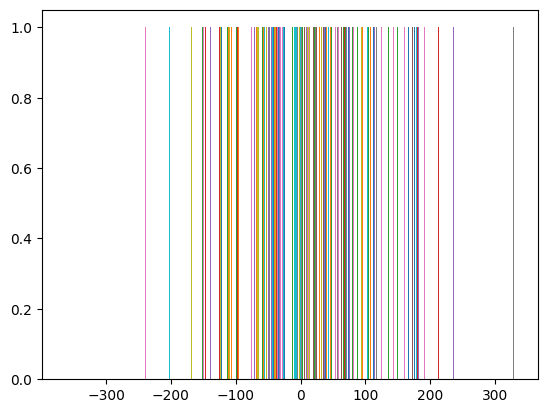

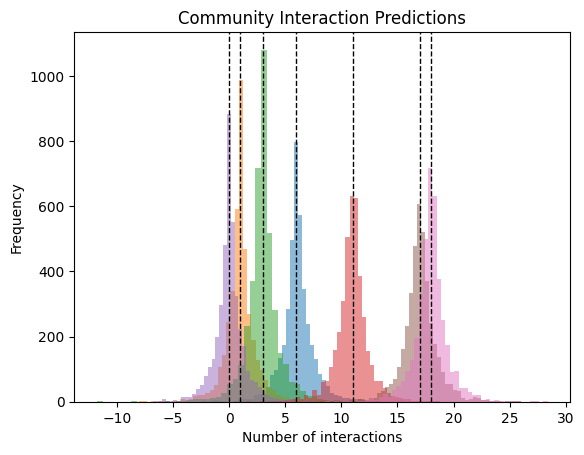

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]  0.052  0.975  -1.800    1.838      0.023    0.019    1864.0   
betas[1] -0.005  0.981  -1.865    1.775      0.019    0.022    2782.0   
betas[2] -0.080  0.963  -1.900    1.730      0.021    0.018    2062.0   
betas[3]  0.058  0.941  -1.648    1.909      0.019    0.019    2483.0   
betas[4] -0.048  0.992  -1.856    1.694      0.051    0.036     390.0   
...         ...    ...     ...      ...        ...      ...       ...   
sigma[2]  0.864  0.584   0.076    1.933      0.013    0.009    1760.0   
sigma[3]  0.924  0.555   0.144    1.950      0.013    0.009    1694.0   
sigma[4]  0.812  0.584   0.011    1.852      0.015    0.011    1108.0   
sigma[5]  0.949  0.577   0.180    1.987      0.027    0.019     153.0   
sigma[6]  0.916  0.570   0.119    1.969      0.013    0.009    1501.0   

          ess_tail  r_hat  
betas[0]     931.0   1.00  
betas[1]    1958.0   1.00  
betas[2]    2071.0   1.00  
betas[3]   

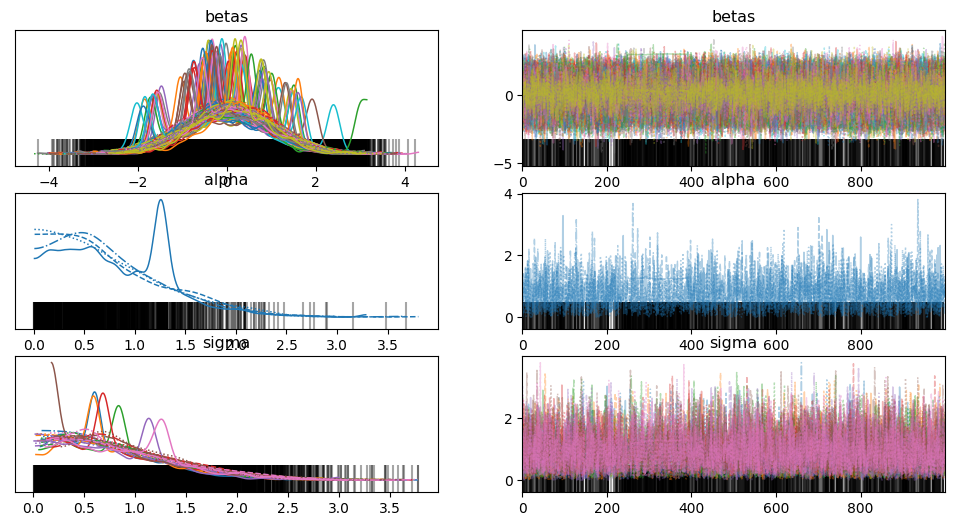

In [ ]:
community_regression_model()
# divergences start about half way through

#### Group Model

In [19]:
group_model = pm.Model()
def group_regression_model():
    global groups, gis
    y = []
    X = []
    g_sum = 0

    for group in range(len(groups)):
        print(gis[group + 1])
        df = pd.DataFrame(gis[group + 1]) - pd.DataFrame(gis[group + 1]).shift(1)
        df.fillna(0, inplace=True)
        print(df)
        X.append(df)
        g = pd.DataFrame(gis[group + 1])
        g_sum += g.sum()

    # get rid of third dimension of X
    X = np.array(X)
    # print(X)
    X = X.reshape(X.shape[0], X.shape[1])

    X = pd.DataFrame(X)

    y = X.iloc[:, -1]
    y.fillna(0, inplace=True)

    X = X.iloc[:, :-1]
    X.fillna(0, inplace=True)

    y = y.to_numpy()
    print(y)

    with group_model:
        try:
            # Data
            group_index = pm.Data("group_index", np.arange(len(groups)), dims="group")
            X_data = pm.Data("X_data", X.T)
            y_data = pm.Data("y_data", y)

            # Priors
            rho = pm.Normal("phi", mu=0, sigma=10, dims="group")
            sigma_ar = pm.Exponential("sigma_ar", lam=1)

            # AR Model
            ar = pm.AR("ar", rho=rho, sigma=sigma_ar, dims="group")

            # Likelihood
            sigma = pm.Exponential("sigma", lam=1)
            y_obs = pm.Normal(
                "y_obs", mu=ar, sigma=sigma, observed=y_data, dims="group"
            )

            # Sampling
            trace = pm.sample(tune=1000, draws=1000)
            posterior_predictive = pm.sample_posterior_predictive(trace)
            prior_predictive = pm.sample_prior_predictive()

        except pm.exceptions.SamplingError:
            warnings.warn("SamplingError: Skipping this group")

    prior = prior_predictive["prior_predictive"]["y_obs"]

    gs = [[] for _ in range(len(groups))]

    for chain in range(prior.shape[0]):
        for draw in range(prior.shape[1]):
            for g in range(prior.shape[2]):
                gs[g].append(prior[chain, draw, g])

    for g in gs:
        plt.hist(g)
    plt.show()

    pred = posterior_predictive["posterior_predictive"]["y_obs"].to_numpy()

    shape = pred.shape
    groups1 = shape[2]

    # Initialize list of lists for each community
    preds = [[] for _ in range(groups1)]

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(groups1):
                preds[k].append(pred[i, j, k])

    for k in range(groups1):
        plt.hist(preds[k], bins=50, alpha=0.5)
        plt.axvline(y[k], color="k", linestyle="dashed", linewidth=1)
        plt.title("Group Interaction Predictions")
        plt.xlabel("Number of interactions")
        plt.ylabel("Frequency")
    plt.show()

    print(az.summary(trace))

    az.plot_trace(trace)

In [20]:
group_regression_model()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
      0
0   0.0
1   0.0
2   0.0
3   0.0
4   0.0
..  ...
95  0.0
96  0.0
97  0.0
98  0.0
99  0.0

[100 rows x 1 columns]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
      0
0   0.0
1   0.0
2   0.0
3   0.0
4   0.0
..  ...
95  0.0
96  0.0
97  0.0
98  0.0
99  0.0

[100 rows x 1 columns]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 1, 2, 1, 1, 2, 1, 3, 1, 2, 4, 1, 1, 2, 2, 2, 3, 2, 1, 3, 3, 6, 4, 3, 4, 6, 3, 4, 5, 6, 4, 7, 4, 2, 2, 3, 4, 6, 5, 5, 7

C:\Users\gian\AppData\Local\Temp\ipykernel_55848\927727451.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


IndexError: tuple index out of range

In [17]:
user_model = pm.Model()
def user_choice_model():
    global users, groups, communities, group_relative_frequency, community_relative_frequency
    # multinomial logit model for group interactions
    num_groups = len(groups)
    y = []
    X = []

    for user in users:
        if len(user.interaction_history) == 0:
            y.append(0)
        else:
            y.append(user.interaction_history[-1])
        # every interaction but the last one
        X.append(np.bincount(user.interaction_history[:-1], minlength=num_groups))

    X = pd.DataFrame(X)
    X.fillna(0, inplace=True)

    y = pd.DataFrame(y)
    y = y.iloc[:, 0]

    # drop first column if sum is 0
    if X.iloc[:, 0].sum() == 0:
        X = X.iloc[:, 1:]
        # if num_groups != X.shape[1]:
        #    num_groups -= (X.shape[1] - num_groups)

    for row in range(len(X)):
        X.iloc[row] = X.iloc[row] / X.iloc[row].sum()

    X.fillna(0, inplace=True)
    X = (X - X.mean()) / X.std()
    X.fillna(0, inplace=True)

    with user_model:
        try:
            indices = pm.Data("index", list(range(len(X))), dims="user")
            # Define your data within the model
            X_data = pm.Data("X_data", X)
            y_data = pm.Data("y_data", y)

            # Model parameters

            alpha = pm.Exponential(
                "alpha", lam=np.max(group_relative_frequency), shape=num_groups
            )

            beta_mu = pm.Normal("beta_mu", mu=1, sigma=10, shape=num_groups)
            beta_sd = pm.TruncatedNormal(
                "beta_sd", lower=0, mu=5, sigma=2.5, shape=num_groups
            )

            beta = pm.Normal(
                "beta", mu=beta_mu, sigma=beta_sd, shape=(num_groups, num_groups)
            )

            # Computing mu
            mu = alpha + pm.math.dot(X_data, beta)

            # A numerically stable softmax
            mu_max = pm.math.max(mu, axis=1, keepdims=True)
            p = pm.Deterministic(
                "p",
                pm.math.exp(mu - mu_max)
                / pm.math.sum(pm.math.exp(mu - mu_max), axis=1, keepdims=True),
            )

            # Categorical distribution for observed data
            y_obs = pm.Categorical("y_obs", p=p, observed=y_data, dims="user")

            # Sampling
            trace = pm.sample(tune=5000, draws=5000)
            posterior_predictive = pm.sample_posterior_predictive(trace)
            prior_predictive = pm.sample_prior_predictive()

        except pm.exceptions.SamplingError:
            user_model.debug(verbose=True)

        print(az.summary(trace))

        az.plot_trace(trace)

        y_pred = np.rint(
            posterior_predictive["posterior_predictive"]["y_obs"].mean(axis=(0, 1))
        )

        plt.scatter(y, y_pred)
        plt.xlabel("Actual Group ID")
        plt.ylabel("Predicted Group ID")
        plt.show()

        plt.scatter(y, y_pred - y)
        plt.xlabel("Actual Group ID")
        plt.ylabel("Residual")
        plt.show()

        print(az.summary(trace))

        plt.hist(y_pred, bins=num_groups, alpha=0.5, label="Predicted")
        plt.hist(y, bins=num_groups, alpha=0.5, label="Actual")
        plt.legend(loc="upper right")
        plt.xlabel("Group ID")
        plt.ylabel("Frequency")
        plt.show()
        samples = posterior_predictive["posterior_predictive"]["y_obs"].to_numpy()
        users = [[] for _ in range(samples.shape[2])]
        for chain in range(samples.shape[0]):
            for draw in range(samples.shape[1]):
                for user in range(samples.shape[2]):
                    users[user].append(samples[chain, draw, user])

        # Define the grid layout
        num_users = len(users)
        num_rows = int(num_users**0.5)  # Number of rows in the grid
        num_cols = (
            num_users + num_rows - 1
        ) // num_rows  # Number of columns in the grid

        # Create subplots
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

        # Iterate through users and plot histograms
        for user_idx, ax in enumerate(axes.flat):
            if user_idx < num_users:
                user_data = users[user_idx]
                actual_interaction = y[user_idx]

                ax.hist(user_data, bins=num_groups)
                ax.axvline(
                    actual_interaction, color="r", linestyle="dashed", linewidth=1
                )

                ax.set_title(f"User {user_idx + 1}")
                ax.set_xlabel("Interactions")
                ax.set_ylabel("Frequency")

        # Remove any empty subplots
        for user_idx in range(num_users, num_rows * num_cols):
            fig.delaxes(axes.flat[user_idx])

        plt.tight_layout()
        plt.show()

In [18]:
user_choice_model()

c:\Users\gian\miniconda3\envs\treten\lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


ValueError: ('shapes (89,22) and (23,23) not aligned: 22 (dim 1) != 23 (dim 0)', (89, 22), (23, 23))
Apply node that caused the error: Dot22(X_data{[[ 0. ... 10599979]]}, beta)
Toposort index: 0
Inputs types: [TensorType(float64, shape=(89, 22)), TensorType(float64, shape=(23, 23))]
Inputs shapes: [(89, 22), (23, 23)]
Inputs strides: [(8, 712), (184, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Add(ExpandDims{axis=0}.0, Dot22.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "C:\Users\gian\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
    result = self._run_cell(
  File "C:\Users\gian\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
    return runner(coro)
  File "C:\Users\gian\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\gian\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\gian\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "C:\Users\gian\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\gian\AppData\Local\Temp\ipykernel_55848\3956216978.py", line 1, in <module>
    user_choice_model()
  File "C:\Users\gian\AppData\Local\Temp\ipykernel_55848\1304350543.py", line 59, in user_choice_model
    mu = alpha + pm.math.dot(X_data, beta)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.